<center>  <h1> Data 598 (Winter 2023): Midterm </h1> </center> 
    <center> University of Washington </center>
    

There are four parts in this midterm. 
1. Understanding automatic differentiation
1. Programming a differentiable module
1. Optimization a neural network
1. Explaining data science to a friend

**Rules**: 
- You may refer to the reference books.
- You may refer to the labs, demos, lab solutions and homework solutions. 
- However, you may not directly copy-paste code from any of the labs or demos. You should write your own code.
- The only exception to the copy-paste rule is where explicitly specified. 

# Part 1: Understanding automatic differentiation

Consider the function $f: \mathbb{R} \to \mathbb{R}$ defined as 

$$
    f(x) =  \sqrt{2 + x^3 + \log (1+ x^3)} + \sin(2 + x^3 + \log (1+ x^3)) .
$$

<!-- $$
    f(x) = \sqrt{x^2 + \exp (x^2)} + \cos(x^2 + \exp(x^2)) \,.
$$ -->

Questions:

**B)** Write out the chain rule to compute the derivative $f'(x)$ of $f$ at a given $x$. 
You may insert the equations in Markdown directly using LaTeX syntax. 

**Your answer here**: 
*A few different ways to use the chain rule*
$$ \mu = 2 + x^3 + log(1+x^3)\\
\text{Then},
\frac{df}{dx} = \frac{df}{du}\frac{du}{dx}
$$





**C)** Implement this function $f$ in code so that it accepts a scalar $x$ and returns $f(x)$. 

In [1]:
import torch
def my_function(x):
    # x is a torch.tensor (this is the PyTorch scalar type)
    # Example input `x = torch.tensor(3.14159, requires_grad=True)`
    # TODO: your code here
    a = x**3
    b = 2 + a
    c = 1 + a
    d = torch.log(c)
    e = b + d 
    f = torch.sqrt(e)
    g = torch.sin(e)
    h = f + g
    return h

**D)** Compute the derivative $f'(x)$ for $x= 1.432$ using PyTorch's automatic differentiation. You do not have to code up your own backward method. 

In [3]:
# TODO: your code here
x = torch.tensor(1.432, requires_grad=True)
y = my_function(x)
grad = torch.autograd.grad(outputs=y, inputs=x)[0]
print(grad)

tensor(9.2485)


# Part 2: Coding up a differentiable module

Consider the soft-thresholding function $f_T: \mathbb{R} \to \mathbb{R}$ defined for any $T > 0$ as 
$$
    f_T(y) = 
    \begin{cases} 
        0, & \text{ if } -T \le y \le T \,, \\
        (y - T)^2, & \text{ if } y > T \,, \\
        (y + T)^3, & \text{ if } y < -T \,.
    \end{cases}
$$



**A)** Write a function to compute which takes in as arguments $y, T$ and returns the soft-thresholding $f_T(y)$.
    Plot this function with $T = 2.81$ in the range $[-15, 15]$.

Text(0, 0.5, 'softt(y, T)')

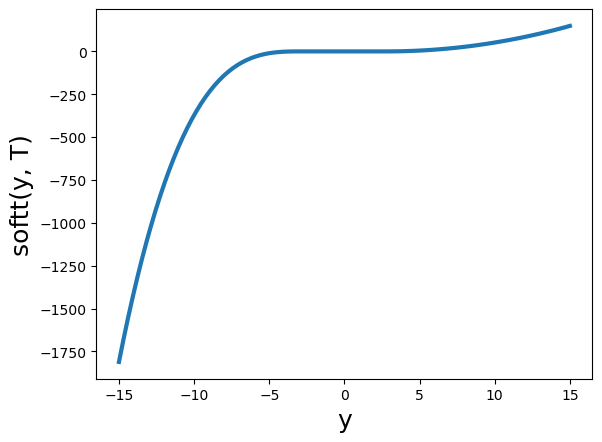

In [26]:
import matplotlib.pyplot as plt
def softt(y, T):
    """ `y` is a torch.tensor (i.e., PyTorch's scalar type; same as above), 
        `T` is a regular Python number (float or int).
        return type: torch.tensor
    """
    # TODO: your code here
    # HINT: if you write a program with branches, make sure that the output type is always a torch.tensor
    if torch.abs(y) <= T:
        return torch.zeros_like(y, requires_grad=True)
    elif y > T:
        return (y - T)**2 
    else:
        return (y + T)**3
    
y = torch.linspace(-15, 15, 100)
z = [softt(a, 2.81).detach().numpy() for a in y]
plt.plot(y, z, linewidth=3)
plt.xlabel('y', fontsize=18)
plt.ylabel('softt(y, T)', fontsize=18)

**B)** Write a function which computes the derivate $f_T'(y)$ of the soft-thresholding function w.r.t. $y$, as returned by PyTorch. Plot this for $T=2.81$ in the range $[-15, 15]$. 

**Hint 1**: If you coded up `softt` using branches, you might encounter a situation where the output does not depend on the input. In this case, you will have to appropriately set the `allow_unused` flag. 

**Hint 2**: When PyTorch returns a derivative of `None`, it actually stands for `0`. If your derivative returns a `None`, you will have to handle this appropriately when plotting the function.

tensor(0.)


Text(0, 0.5, 'softt(y, T)')

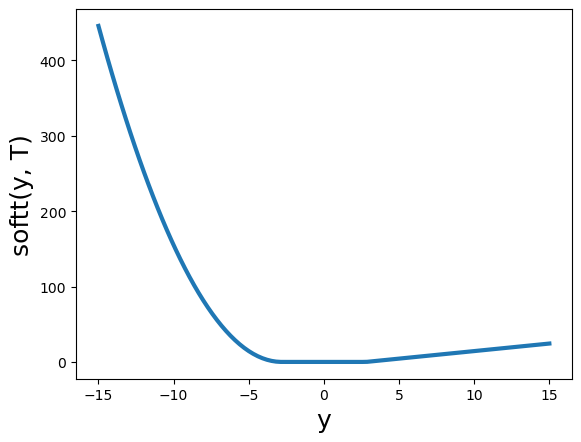

In [27]:
def softt_derivative(y, T): 
    z = softt(y, T)
    deriv = torch.autograd.grad(outputs=z, inputs=[y], allow_unused=True)[0]
    return deriv if deriv is not None else torch.zeros_like(y)

# Test your code
a = torch.tensor(1.20, requires_grad=True)
print(softt_derivative(a, 2.81))

y = torch.linspace(-15, 15, 100, requires_grad=True)
z = [softt_derivative(a, 2.81) for a in y]
plt.plot(y.detach(), z, linewidth=3)
plt.xlabel('y', fontsize=18)
plt.ylabel('softt(y, T)', fontsize=18)

**C)** We will now code a differentiable module using `torch.nn.Module`. 

First, let us extend the definition of 
the soft-thresholding $f_T$ to vectors by applying the soft-thresholding operation component-wise. 

Now write a differentiable module which implements the transformation $g_{T}(\cdot; M): \mathbb{R}^d \to \mathbb{R}^d$ 
given by 
$$
    g_{T}(x; M) = M^{-1} \, f_T(Mx) \,,
$$
where $M \in \mathbb{R}^{d \times d}$, a symmetric matrix, is a *parameter* of the module. (Recall: parameters maintain state of the module; register a parameter in `torch.nn.Module` by using the `torch.nn.Parameter` wrapper).

Supply $T > 0$ and and initial value $M_0 \in \mathbb{R}^{d \times d}$ symmetric to the constructor, while the `forward` method only accepts $x \in \mathbb{R}^d$ as an input. 

You may use the function `create_symmetric_invertible_matrix` to create this matrix `M`.

In [28]:
class MatmulSofttMatmulinv(torch.nn.Module):
    #### TODO: your code here
    def __init__(self, M0, T):
        super().__init__()
        self.M = torch.nn.Parameter(M0)
        self.T = T
        
    def forward(self, x):
        return torch.matmul(
            torch.inverse(self.M),
            softt_vectorized(torch.matmul(self.M, x), self.T)
        )

def softt_vectorized(x, T):
    y = torch.zeros_like(x)
    y[x < -T] = x[x < -T] + T
    y[x > T] = x[x > T] - T
    return y

**D)** Initialize the module with $T = 2.81$ and $M_0$ using the function `create_symmetric_invertible_matrix`. 
Use `dimension=5`. Pass in the following vector `x` defined below and compute $g_T(x;M_0)$.

In [29]:
import numpy as np
def create_symmetric_invertible_matrix(dimension):
    # return symmetric invertible square matrix of size `dimension` x `dimension`
    rng = np.random.RandomState(dimension)
    factor = rng.randn(dimension, dimension).astype(np.float32)
    return 1e-6 * torch.eye(dimension) + torch.from_numpy(np.matmul(factor, factor.T))

dimension = 5
x = torch.randn(5, requires_grad=True)
print('x:', x)
# TODO: your code here
mymodule = MatmulSofttMatmulinv(create_symmetric_invertible_matrix(dimension), 2.81)
print('output:', mymodule(x))

x: tensor([-1.2433, -0.8555,  1.7036,  0.3253,  1.5343], requires_grad=True)
output: tensor([-2.0683,  2.2825,  2.4173,  2.7674,  1.3480], grad_fn=<MvBackward0>)


**E)** For the same vector `x` as defined above, compute and print out the gradient of $\varphi_T(x; M) = \|x - g_T(x; M)\|_2^2$
with respect to both $x$ and $M$ using automatic differentiation. Use $T=2.81$ again.

In [30]:
output = torch.norm(x - mymodule(x))**2
grad = torch.autograd.grad(outputs=output, inputs=[x, mymodule.M])
print('gradient:', grad)

gradient: (tensor([ 5.7220e-06, -4.2915e-06, -1.1921e-07,  8.5831e-06,  2.3842e-07]), tensor([[ -3.5720,  13.5863,   3.0899,  10.5734,  -0.8069],
        [ 11.3942, -43.3389,  -9.8565, -33.7279,   2.5738],
        [  5.1100, -19.4365,  -4.4204, -15.1262,   1.1543],
        [  9.2631, -35.2329,  -8.0130, -27.4195,   2.0924],
        [  1.9725,  -7.5027,  -1.7063,  -5.8389,   0.4456]]))


In [31]:
mymodule = MatmulSofttMatmulinv(create_symmetric_invertible_matrix(dimension), 2.81)
output = torch.norm(x - mymodule(x))**2
grad = torch.autograd.grad(outputs=output, inputs=[x, mymodule.M])
print(grad)

(tensor([ 5.7220e-06, -4.2915e-06, -1.1921e-07,  8.5831e-06,  2.3842e-07]), tensor([[ -3.5720,  13.5863,   3.0899,  10.5734,  -0.8069],
        [ 11.3942, -43.3389,  -9.8565, -33.7279,   2.5738],
        [  5.1100, -19.4365,  -4.4204, -15.1262,   1.1543],
        [  9.2631, -35.2329,  -8.0130, -27.4195,   2.0924],
        [  1.9725,  -7.5027,  -1.7063,  -5.8389,   0.4456]]))


# Part 3: Optimizing a multi-layer perceptron
In this exercise, you will find the divergent learning rate of a MLP and implement a variant of SGD with parameter averaging. 

We will start with the dataloading utilities. 

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


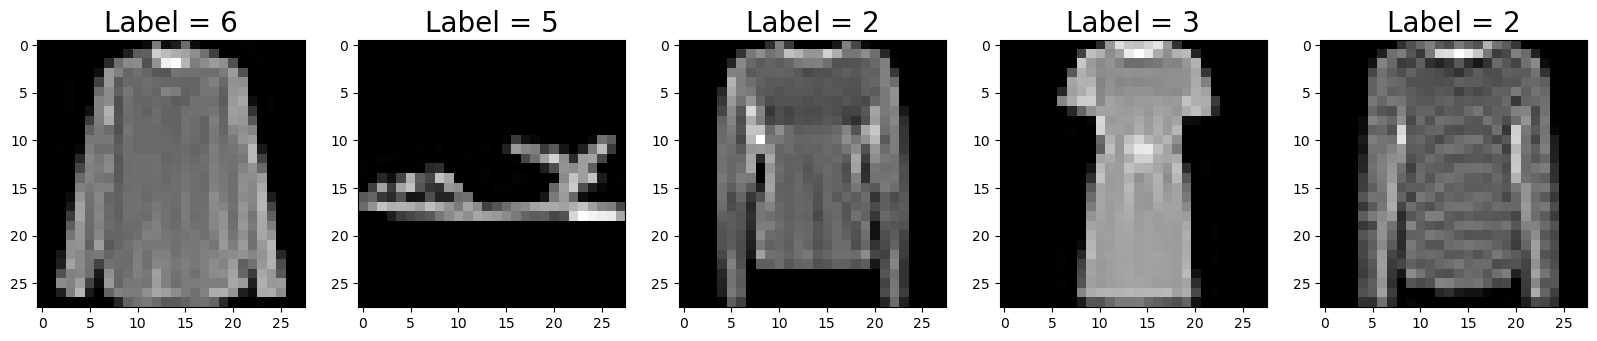

In [17]:
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy

# download dataset (~117M in size)
train_dataset = FashionMNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = FashionMNIST('../data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    


# Normalize dataset: pixel values lie between 0 and 255
# Make them zero mean

X_train = X_train.float()  # convert to float32
X_train = X_train.view(-1, 784)  # flatten into a (n, d) shape
mean, std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mean[None, :]) 

X_test = X_test.float()
X_test = X_test.view(-1, 784)
X_test = (X_test - mean[None, :])

n_class = np.unique(y_train).shape[0]

**A)** Code up a MLP with three hidden layers with 32, 16, and 12 hidden units respectively. We will use a batch size of 8 throughout. The objective function we will use is the multinomial logistic loss, also known in PyTorch as `cross_entropy`. 

You **may reuse** code from previous labs and demos for this part.

In [20]:
from torch.nn.functional import cross_entropy
import copy

class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(784, 32)
        self.linear2 = torch.nn.Linear(32, 16)
        self.linear3 = torch.nn.Linear(16, 12)
        self.linear4 = torch.nn.Linear(12, 10)
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

def compute_objective(net, X, y):
    """ Compute the multinomial logistic loss. 
        net is a module
        X of shape (n, d) and y of shape (n,)
    """
    # send 
    score = net(X)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    return cross_entropy(input=score, target=y, reduction='mean') 

@torch.no_grad()
def compute_accuracy(net, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = net(X)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(net, verbose=False):
    train_loss = compute_objective(net, X_train, y_train)
    test_loss = compute_objective(net, X_test, y_test)
    train_accuracy = compute_accuracy(net, X_train, y_train)
    test_accuracy = compute_accuracy(net, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def minibatch_sgd_one_pass(net, net_avg, X, y, learning_rate, batch_size, average_weight=1e-3, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        # TODO: your code here: sample `batch_size` many indices from {0, ..., num_examples-1}
        idxs = np.random.choice(num_examples, size=(batch_size,)) 
        # compute the objective. 
        objective = compute_objective(net, X[idxs], y[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # TODO: your code here: compute the gradient using automatic differentiation
        gradients = torch.autograd.grad(outputs=objective, inputs=net.parameters())
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (w, wa, g) in zip(net.parameters(), net_avg.parameters(), gradients):
                w -= learning_rate * g
                wa *= (1-average_weight)
                wa += average_weight * w
    return net, net_avg

**B)** Find the divergent learning rate.

**Note**: We changed the data pre-processing (our data no longer has unit variance), which could cause the divergent learning rate to be different from what we had previously. There are other issues associated with not normalizing the scale of the data. 

In [21]:

net = MLP()
net_avg = copy.deepcopy(net)
_ = compute_logs(net_avg, verbose=True)

learning_rate = 2e-3
batch_size = 8

minibatch_sgd_one_pass(net, net_avg, X_train, y_train, 
                       learning_rate, batch_size, 
                       average_weight=1e-3, verbose=True)

Train Loss = 13.663, Train Accuracy = 0.047, Test Loss = 13.578, Test Accuracy = 0.053
1.729959273446069
1.1886902581072505
0.8786620894286425
0.772673354612931
0.7082869127859819
0.652983895545256
0.6163507568385315


(MLP(
   (linear1): Linear(in_features=784, out_features=32, bias=True)
   (linear2): Linear(in_features=32, out_features=16, bias=True)
   (linear3): Linear(in_features=16, out_features=12, bias=True)
   (linear4): Linear(in_features=12, out_features=10, bias=True)
 ),
 MLP(
   (linear1): Linear(in_features=784, out_features=32, bias=True)
   (linear2): Linear(in_features=32, out_features=16, bias=True)
   (linear3): Linear(in_features=16, out_features=12, bias=True)
   (linear4): Linear(in_features=12, out_features=10, bias=True)
 ))

**C)** We will implement averaged SGD with an exponentially moving average. 
In addition to the model parameters $w_t$, we 
also maintain a separate set of parameters $\bar w_t$ to serve as an average. The update of averaged SGD proceed 
as: 
$$
    w_{t+1} = w_t - \eta g_t \\
    \bar w_{t+1} = (1 - \gamma) \bar w_t + \gamma w_{t+1},
$$
where $\eta$ is a learning rate, $g_t$ is a (minibatch) stochastic gradient at $w_t$ and $\gamma \in (0, 1)$ is an average weight. 

Note that the averaged parameter $\bar w_t$ is *not* used during the stochastic gradient updates; it is updated on the side and never to be used in model updates. We use $\bar w_t$ for logging only. 

Your task is to train the model for $25$ epochs and plot the train/test loss/accuracy for both the unaveraged model $w_t$ as well as the averaged_model $\bar w_t$ in the same plot. Use a batch size of $8$ and half the divergent learning rate you found in the previous part. We will use the average weight as $\gamma = 10^{-3}$.


Do not include a plot of the first two passes through the data.
 
    

In [22]:

net = MLP()
net_avg = copy.deepcopy(net)
logs = [compute_logs(net, verbose=True)]
logs_avg = [compute_logs(net_avg, verbose=True)]

learning_rate = 1e-3

for j in range(25):
    _ = minibatch_sgd_one_pass(
        net, net_avg, X_train, y_train, learning_rate, batch_size=batch_size, verbose=False)
    print(f'Iteration {j+1}', end=', ')
    logs.append(compute_logs(net, verbose=True))
    logs_avg.append(compute_logs(net_avg, verbose=True))

logs = np.asarray(logs)
logs_avg = np.asarray(logs_avg)

Train Loss = 8.388, Train Accuracy = 0.150, Test Loss = 8.522, Test Accuracy = 0.148
Train Loss = 8.388, Train Accuracy = 0.150, Test Loss = 8.522, Test Accuracy = 0.148
Iteration 1, Train Loss = 0.549, Train Accuracy = 0.808, Test Loss = 0.686, Test Accuracy = 0.780
Train Loss = 1.374, Train Accuracy = 0.663, Test Loss = 1.527, Test Accuracy = 0.636
Iteration 2, Train Loss = 0.451, Train Accuracy = 0.847, Test Loss = 0.616, Test Accuracy = 0.802
Train Loss = 0.632, Train Accuracy = 0.800, Test Loss = 0.798, Test Accuracy = 0.762
Iteration 3, Train Loss = 0.449, Train Accuracy = 0.848, Test Loss = 0.608, Test Accuracy = 0.801
Train Loss = 0.459, Train Accuracy = 0.843, Test Loss = 0.634, Test Accuracy = 0.799
Iteration 4, Train Loss = 0.416, Train Accuracy = 0.849, Test Loss = 0.613, Test Accuracy = 0.801
Train Loss = 0.392, Train Accuracy = 0.865, Test Loss = 0.573, Test Accuracy = 0.812
Iteration 5, Train Loss = 0.401, Train Accuracy = 0.858, Test Loss = 0.633, Test Accuracy = 0.799


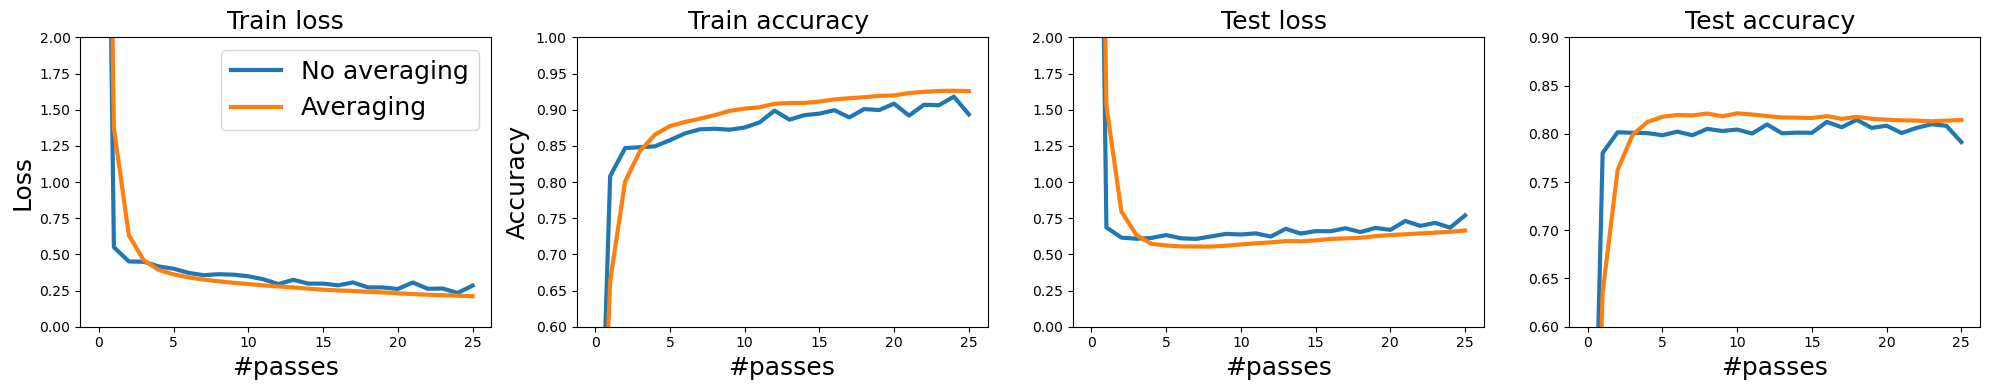

In [23]:


f, ax = plt.subplots(1, 4, figsize=(20, 4))
for a in ax: a.set_xlabel('#passes', fontsize=18)
for a in [ax[0], ax[2]]: ax[0].set_ylabel('Loss', fontsize=18)
for a in [ax[1], ax[3]]: ax[1].set_ylabel('Accuracy', fontsize=18)
ax[0].set_title(f'Train loss', fontsize=18)
ax[1].set_title(f'Train accuracy ', fontsize=18)
ax[2].set_title(f'Test loss ', fontsize=18)
ax[3].set_title(f'Test accuracy ', fontsize=18)

ax[0].plot(logs[:, 0], linewidth=3, label="No averaging")
ax[1].plot(logs[:, 1], linewidth=3)
ax[2].plot(logs[:, 2], linewidth=3)
ax[3].plot(logs[:, 3], linewidth=3)
ax[0].plot(logs_avg[:, 0], linewidth=3, label="Averaging")
ax[1].plot(logs_avg[:, 1], linewidth=3)
ax[2].plot(logs_avg[:, 2], linewidth=3)
ax[3].plot(logs_avg[:, 3], linewidth=3)

ax[0].set_ylim((0, 2))
ax[2].set_ylim((0, 2))
ax[1].set_ylim((0.6, 1.0))
ax[3].set_ylim((0.6, 0.9))

ax[0].legend(fontsize=18)
plt.tight_layout()

# Part 5: CNN Open Ended

Choose **1 from each section** of the following problems.

**Section 1 (choose 1)**

a. Given a image of size =20 , what is the output shape if it put through a convulation neural net of kernel size=3, padding = 2, and stride = 4, and number of out_channels = 16? Justify your answer based on the ideas of kernel size, padding, and stride. 

b. For text data, what does a stride of 2 correspond to? Specifically, what other kind of metric could it be called?

c. Do we need a separate minimum pooling layer? Can you replace it with another operation?

**Section 2 (choose 1)**

d. What are the computational and statistical benefits of a stride larger than 1?

e. What is the computational cost of the pooling layer? Assume that the input to the pooling layer is of size $c\times h\times w$,the pooling window has a shape of $p_h \times p_w$ with a padding of $(p_h, p_w)$ and a stride of $(s_h, s_w)$.

SOLUTIONS
**Section 1 (choose 1)**

a. [1, 16, 6, 6] --> see code below

b. The convoluation of 2 tokens, in NLP this is known as a bi-gram. 

c. You can simply multiply the matrix X by -1 and then do max pooling.

**Section 2 (choose 1)**

c. Computational: you get more efficient calculations (less computations), speed up training due to less computations
   Statistical: you simplify the model as you increase layers, avoid overfitting to the training data (related to "downsampling")

d. (h-ph-sh)/sh * (w-pw-sw)/sw *C. But in terms of computational complexity it is O(n), n is the number of computational windows.

In [25]:
#1.a [1, 16, 6, 6]
import torch
convolution_layer = torch.nn.Conv2d(
    in_channels=3, out_channels=16, kernel_size=3,
    padding=2, stride=4
)
image_size = 20
random_images = torch.randn(1, 3, image_size, image_size) 
# 1 is the batch dimension; 3 is the number of channles
# batch dimension: the convolution operation is applied in parallel for element of the batch

output = convolution_layer(random_images)
## Exercise: parse the shape of the output
print(output.shape)

torch.Size([1, 16, 6, 6])


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
